### MNIST with Keras in TF2
From [tensorflow tutorial](https://www.tensorflow.org/tutorials/quickstart/advanced)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tqdm import tqdm_notebook as tqdm

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

Show an example of MNIST training data

1042


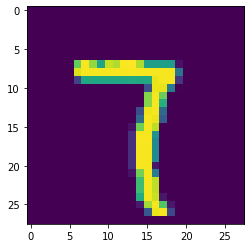

In [11]:
%matplotlib inline 
import numpy as np
import random
from matplotlib import pyplot as plt

number = random.randrange(60000)
print (number)
plt.imshow(np.squeeze(x_train[number]))
plt.show()

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [5]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [6]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [7]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [8]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [9]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [10]:
EPOCHS = 10

for epoch in tqdm(range(EPOCHS), desc='Epoch'):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Test Loss: {:.3f}, Test Accuracy: {:.3f}'
  print(template.format(epoch+1,
                        float(train_loss.result()),
                        float(train_accuracy.result())*100,
                        float(test_loss.result()),
                        float(test_accuracy.result())*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.136, Accuracy: 96.002, Test Loss: 0.057, Test Accuracy: 98.240
Epoch 2, Loss: 0.041, Accuracy: 98.713, Test Loss: 0.054, Test Accuracy: 98.230
Epoch 3, Loss: 0.022, Accuracy: 99.308, Test Loss: 0.058, Test Accuracy: 98.240
Epoch 4, Loss: 0.013, Accuracy: 99.570, Test Loss: 0.071, Test Accuracy: 98.010
Epoch 5, Loss: 0.011, Accuracy: 99.658, Test Loss: 0.056, Test Accuracy: 98.460
Epoch 6, Loss: 0.006, Accuracy: 99.808, Test Loss: 0.073, Test Accuracy: 98.280
Epoch 7, Loss: 0.006, Accura